This notebook creates synthetic displacement time series (same rate, random noise added for nn iterations) and does an inversion with made-up coherence values. In addition to adding noise associated with each date (affecting two igrams), I add noise associated with each igram (only affecting one) on one date, to simulate speckle/decorrelation rather than atmospheric noise. 

This notebook: <br>
1. creates displacement data (single time series) by adding noise to a constant velocity time series (line). This has irregularly-sampled time intervals to show that it works without constant dt.
2. makes coherence values to accompany the data, one value has higher error/standard deviation 
3. creates covariance matrix using noise levels defined above plus noise associated with one interferogram (speckle)
4. Inverts using the disp over time method.
5. Plots everything.

This notebook was written on 12-19-22. Edited 1-26-23. Edited 12-19-23.

***

In [1]:
# import stuff
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib  widget

In [2]:
# set the random seed so it produces the same figure each time.
np.random.seed(2147483648)
# number of SLCs
nd = 11 
# velocity 
V = 5
# times
t = np.linspace(0,1,nd+1)
# skip the second regularly-spaced time to show that it works without equal sampling intervals 
t = np.hstack((t[0:3],t[4::])); t=t.T
# true disp time series
true_disp = V*t
# get dt (time intervals of igrams)
dt = np.diff(t)
# calculate igram disps 
true_igram_disps = np.diff(true_disp)
# coherences
coh = np.ones(nd-1)*0.9
coh[6] = 0.15 # bad coherence on this day 
# variances (calculated from coherences)
vars = (-2*np.log(coh))  


# add noise here 
# two igrams will be noisy, don't know which has unwrapping error 
# pick first one that is affected, add 2pi 
igram_disps = true_igram_disps + vars*np.random.randn(nd-1,)

# so I can convert a 2pi unwrapping error into displacement in cm (or whatever unit is on y-axis, undefined actually)
wavelength = 5.5465763                                      # C-band, in cm 
rad2cm = wavelength/(4*np.pi)   

igram_disps[6] = igram_disps[6]- (2*np.pi)*rad2cm


vars_diag = np.diag(vars,0)
# date-related noise
noise_diags = np.ones(nd-1)             # ones on diagonal 
noise_off_diags = np.ones(nd-2)*(-0.5)  # -0.5 on off diagonals
covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1)+np.diag(noise_off_diags,1) 
# add two noise matrices together 
covi2 = vars_diag+covi
# take the inverse
icov = np.linalg.inv(covi2)
# G matrix is from dt, but reshaped
G = (dt.T).reshape(nd-1,1)
# solve for Gg (which is what is multiplied by disps to get rate)
Gg = np.linalg.inv(G.T.dot(icov).dot(G)).dot(G.T).dot(icov)

# add noise to disp rates/igram
#igram_disps = true_igram_disps + vars_diag.dot(np.random.randn(nd-1,)) # shouldn't be adding noise here

cum_igram_disps = np.hstack((0,np.cumsum(igram_disps)))

# solve for rate using weighted inversion of disp rates
weighted_vel = Gg.dot(igram_disps)[0]
#print((weighted_vel))

# now do the line fit from cumulative displacements
cum_disp_vel, cum_disp_intercept = np.polyfit(t,cum_igram_disps,deg=1) 

# calculate the disps/unit time from the disps/igram
igram_disp_rates = igram_disps/dt
true_disp_rates = true_igram_disps/dt


/tmp/ipykernel_115735/4017992016.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Coherence', pad=0.02)


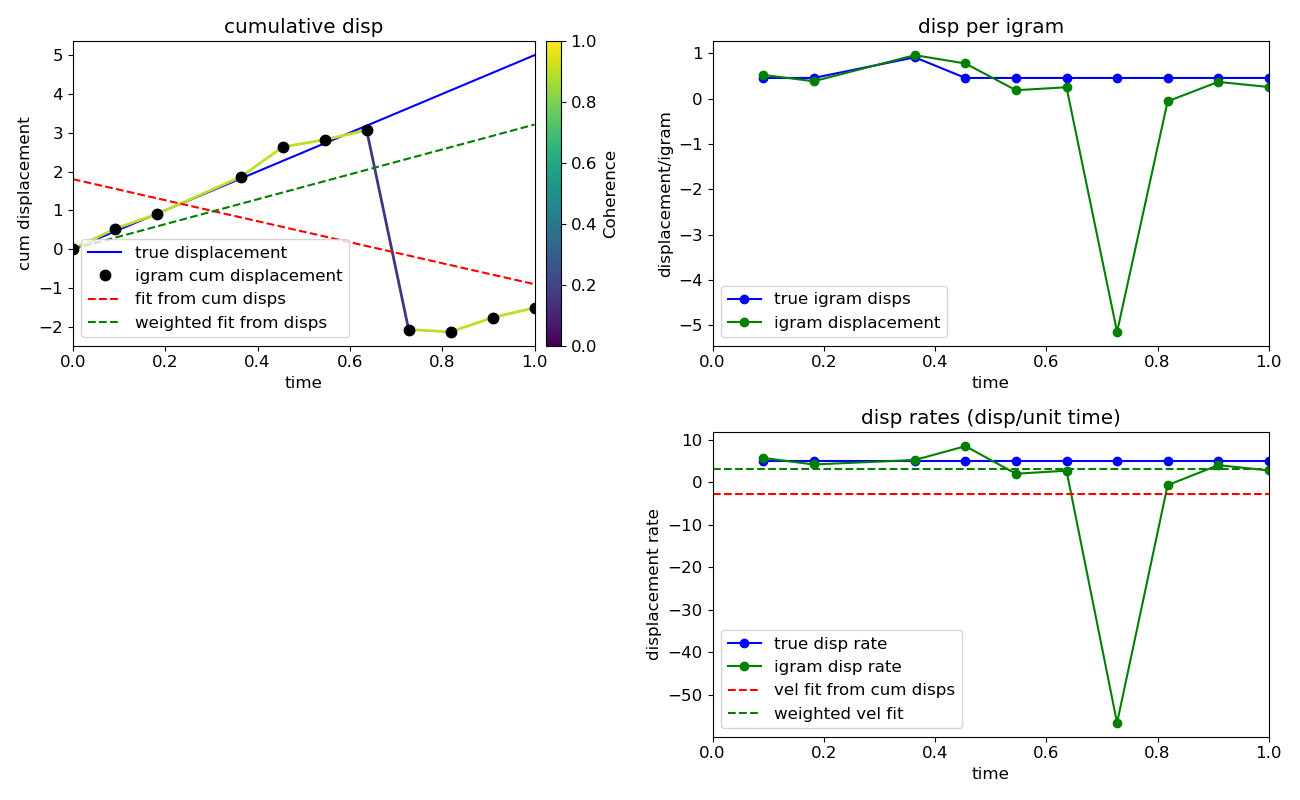

In [9]:
vir2 = cm.get_cmap('viridis',1000)
# plot it. 
plt.figure(figsize=(13,8),tight_layout=True)
plt.subplot(2,2,1)
plt.plot(t,true_disp,'b-',label='true displacement')
#plt.plot(t,cum_igram_disps,'k:')
#plt.scatter(t[1::],cum_igram_disps[1::],c=coh,label='igram cum displacement',vmin=0.0,vmax=1.0,zorder=10)
plt.plot(t,cum_igram_disps,'k.',markersize=15,zorder=10,label='igram cum displacement')
for i in range(nd-1):
    plt.plot([t[i],t[i+1]],[cum_igram_disps[i],cum_igram_disps[i+1]],'-',linewidth=2,c=vir2(coh[i]))
norm = mpl.colors.Normalize(vmin=0.0,vmax=1.0)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Coherence', pad=0.02)

plt.plot([t[0],t[-1]],[t[0]+cum_disp_intercept,t[-1]*cum_disp_vel+cum_disp_intercept],'r--',label='fit from cum disps')
plt.plot([t[0],t[-1]],[0,t[-1]*weighted_vel],'g--',label='weighted fit from disps')
plt.legend(); plt.xlim([0,1])
plt.ylabel('cum displacement'); plt.xlabel('time')
plt.title('cumulative disp')

plt.subplot(2,2,2)
plt.plot(t[1::],true_igram_disps,'b-o',label='true igram disps')
plt.plot(t[1::],igram_disps,'g-o',label='igram displacement')
plt.legend(); plt.xlim([0,1])
plt.ylabel('displacement/igram'); plt.xlabel('time')
plt.title('disp per igram')

plt.subplot(2,2,4)
plt.plot(t[1::],true_disp_rates,'b-o',label='true disp rate')
plt.plot(t[1::],igram_disp_rates,'g-o',label='igram disp rate')
plt.hlines(y=cum_disp_vel,xmin=0,xmax=1,linestyle='--',color='r',label='vel fit from cum disps')
plt.hlines(y=weighted_vel,xmin=0,xmax=1,linestyle='--',color='g',label='weighted vel fit')
plt.legend(); plt.xlim([0,1])
plt.ylabel('displacement rate'); plt.xlabel('time')
plt.title('disp rates (disp/unit time)')

plt.show()

Create synthetic data.

In [4]:
%%script echo skipping

nd = 10                     # number of dates
V = 12                      # velocity 
Sig = 0.8*np.ones((nd,))    # noise std. dev vector 
print('noise std array: '+str(np.shape(Sig)))
Sig[7] = 10.0                  # bigger noise on the 9th date
print('Variances/Sigs: '+str(Sig))
Sigm = np.diag(Sig,0)       # same as Cd?
print('Sigm: \n'+str(Sigm))
# Make an array of dates, with first time interval twice as long as the others.
# this shows that the approach doesn't require constant time intervals.
t = np.linspace(0,1,nd+1)
t = np.hstack((t[0],t[2::])); t=t.T
print('t: '+str(t))
# vector of displacement (D) and noise (N) and noisy disp (ND)
D = V*t
N = Sigm.dot(np.random.randn(nd,))  # for adding noise to dates
N2 = np.zeros((nd-1,)).T 



#N2[2] = 0.8*np.random.randn(1)  # adds more noise to a single igram. 
N2 = N2.reshape((nd-1,1))


DN = N+D
#DN[7::] = DN[7::]+5
# coherence
coh = np.exp(-(Sig**2)/2)   
print('coh: '+str(coh))  
print('D: '+str(D))
print('N: '+str(N))
print('N2: '+str(N2))
print('DN: '+str(DN))

skipping


In [5]:
%%script echo skipping
# plot it
plt.figure(figsize=(5,3),tight_layout=True)
plt.fill_between(t,D+Sig,D-Sig,color='lightgray',label='error bounds')
plt.plot(t,D,color='blue',label='true displacement')
plt.plot(t,DN,'k:',)
plt.scatter(t,DN,c=coh,label='interferogram displacement',vmin=0.0,vmax=1.0) # only plotting one iteration of noise 
plt.legend(loc='upper left'); plt.colorbar(label='coherence')
plt.ylabel('displacement'); plt.xlabel('time')
plt.show()

skipping


In [6]:
%%script echo skipping
# inversions using displacements (slope and intercept)
Gd = np.hstack((t.reshape((nd,1)),(np.ones((nd,1))))) # 10x2
print('Gd: \t'+str(np.shape(Gd)))
Ggdb = ((np.linalg.inv(Gd.T.dot(np.linalg.inv(Sigm**2)).dot(Gd))).dot(Gd.T)).dot(np.linalg.inv(Sigm**2))    # weighted, 2x10 
print('Ggdb: \t'+str(np.shape(Ggdb)))
# now do the inversion for displacement, followed by inversion for V
d = DN.reshape(nd,1) # first iteration of adding noise to igram data              # constraint
print('d: \t'+str(np.shape(d)))

diags = np.ones((nd-1))
Gint = np.diag(diags,1)-1*np.eye(nd)
Gint = Gint[0:-1,:]
print('Gint: '+str(np.shape(Gint)))
ints = Gint.dot(d)  
ints = ints+N2
print('ints: '+str(np.shape(ints)))  

#print(np.shape(N2))


to_stack = (np.ones((nd,1))/(nd-1)).T    # avg=0 constraint 
G1 = np.vstack((Gint,to_stack))
print('G1: '+str(np.shape(G1)))
Gg1b = ((np.linalg.inv(G1.T.dot(np.linalg.inv(Sigm**2)).dot(G1))).dot(G1.T)).dot(np.linalg.inv(Sigm**2))    # weighted      
print('Gg1b: '+str(np.shape(Gg1b)))         
Db = Gg1b.dot(np.vstack((ints,0))) # constraint
print('Db: '+str(np.shape(Db)))
Vdb = Ggdb.dot(Db)  
print('Vdb: '+str(np.shape(Vdb)))              # actually 2 parameters, slope and intercept 
covVb = G1.dot((Sigm**2)).dot(G1.T)

print('weighted V from disps: '+str(Vdb[0][0]))
print('intercept: '+str(Vdb[1][0]))
#print('inv disp, then V with sigma: '+str(np.sqrt(covVb[0,0]))) # not sure what this means 

line = t*Vdb[0][0] + Vdb[1][0]

# regular (non-weighted) polyfit
m,b = np.polyfit(t,DN,1)
line_unweighted = m*t+b 

skipping


In [7]:
%%script echo skipping
plt.figure(figsize=(8,3),tight_layout='TRUE')
#plt.fill_between(t,DN+Sig,DN-Sig,color='lightgray',label='error bounds')
plt.errorbar(t,DN,Sig,color='gray',label='error bounds',fmt='none',zorder=1)
plt.plot(t,D,'b-',label='true disp')
plt.plot(t,d,'k:') # only plotting one iteration of noise 
plt.scatter(t,DN,c=coh,vmin=0.0,vmax=1.0,label='disp+noise')
plt.plot(t,line_unweighted,'r--',label='unweighted fit')
#plt.plot(t,line-line[0],'g--',label='weighted fit')

Ymin,Ymax = plt.ylim()
Xmin,Xmax = plt.xlim()
Xmax = 1.45
weighted_slope = Vdb[0][0]

for u in range(30):
    intercept = -40 + u*2.5
    x_vals = [Xmin,Xmax]
    y_vals = [(intercept),(intercept+weighted_slope*(Xmax-Xmin))]
    plt.plot(x_vals, y_vals, '-', linewidth=1, c='lightgray',zorder=0)
plt.plot(x_vals, y_vals, '-', linewidth=1, c='lightgray',zorder=0, label='weighted fit velocity')


plt.xlabel('time'); plt.ylabel('cumulative displacement'); plt.colorbar(label='coherence',pad=0.03)
plt.xlim([Xmin,Xmax]); plt.ylim([Ymin,Ymax])
plt.legend(loc='center right')
plt.show()

skipping


/tmp/ipykernel_115735/1525757925.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Coherence', pad=0.02)


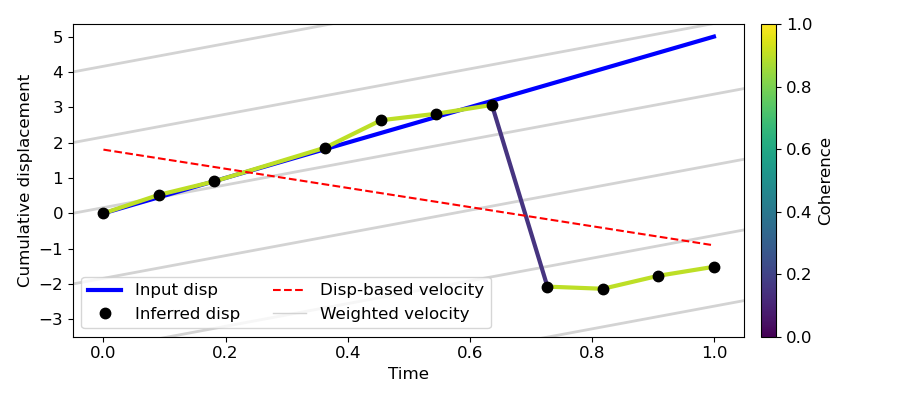

In [8]:
my_cmap = 'viridis' # could also be PRGn for purple-green
plt.rcParams.update({'font.size': 12})
vir2 = cm.get_cmap(my_cmap,1000)


plt.figure(figsize=(9,4),tight_layout='TRUE')
#plt.errorbar(t[1::],cum_igram_disps[1::],vars,color='gray',label='variance',fmt='none',zorder=1)
plt.plot(t,true_disp,'b-',linewidth=3,label='Input disp')
#plt.plot(t,cum_igram_disps,'k:')
#plt.scatter(t[1::],cum_igram_disps[1::],c=coh,label='Inferred disp',cmap='PRGn',vmin=0.0,vmax=1.0,zorder=10)
plt.plot(t,cum_igram_disps,'k.',markersize=15,zorder=10,label='Inferred disp')
for i in range(nd-1):
    plt.plot([t[i],t[i+1]],[cum_igram_disps[i],cum_igram_disps[i+1]],'-',linewidth=3,c=vir2(coh[i]))
norm = mpl.colors.Normalize(vmin=0.0,vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Coherence', pad=0.02)
plt.plot([t[0],t[-1]],[t[0]+cum_disp_intercept,t[-1]*cum_disp_vel+cum_disp_intercept],'r--',label='Disp-based velocity')
# COULD ALSO CALL red dashed line (above) "Standard velocity"
Ymin,Ymax = plt.ylim()
Xmin,Xmax = plt.xlim()
#Xmax = 1.8
for u in range(30):
    intercept = -40 + u*2
    x_vals = [Xmin,Xmax]
    y_vals = [(intercept),(intercept+weighted_vel*(Xmax-Xmin))]
    plt.plot(x_vals, y_vals, '-', linewidth=2, c='lightgray',zorder=0)
plt.plot(x_vals, y_vals, '-', linewidth=1, c='lightgray',zorder=0, label='Weighted velocity')
plt.xlabel('Time'); plt.ylabel('Cumulative displacement')
plt.xlim([Xmin,Xmax]); plt.ylim([Ymin-1,Ymax])
plt.legend(ncol=2,loc='lower left')
#plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/synth_inversion_example.png',transparent=True)
plt.show()